<a href="https://colab.research.google.com/github/talisainen/ICM0031-data-analysis/blob/main/andmeanalyys_projekt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Kursusetöö aines ICM0031, "Andmeanalüüs"


### Aleksei Talisainen, 225287IAXD


---

Data source: https://www.transpordiamet.ee/soidukite-statistika

Import required libraries

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from matplotlib.ticker import MultipleLocator, AutoMinorLocator

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX

Create a dataframe from Excel file

In [ ]:
df = pd.read_excel('/content/eesti-autod-2023.xlsx')

Create a copy of a dataframe

In [ ]:
df_backup = df.copy()

In [ ]:
# Use this to restore the data from backup
# df = df_backup
df.shape

(427050, 28)

I will convert ```ESMANE_REG_KP``` from **YYYY-MM-DD** to **YYYY** and ```EESTIS_ESMAREG_KP``` from **DD.MM.YYYY** to **YYYY**.\
Malformed values are replaced with ```0```

In [ ]:
df['ESMANE_REG_KP'] = pd.to_datetime(df['ESMANE_REG_KP'], format='%Y-%m-%d')
df['ESMANE_REG_KP'] = df['ESMANE_REG_KP'].dt.year
df['ESMANE_REG_KP'] = df['ESMANE_REG_KP'].fillna(0).astype(int)
df['EESTIS_ESMAREG_KP'] = pd.to_datetime(df['EESTIS_ESMAREG_KP'], format='%d.%m.%Y', errors='coerce')
df['EESTIS_ESMAREG_KP'] = df['EESTIS_ESMAREG_KP'].dt.year
df['EESTIS_ESMAREG_KP'] = df['EESTIS_ESMAREG_KP'].fillna(0).astype(int)

In [ ]:
df.head(5)

,Andmed seisuga,YLDINE_STAATUS,EESTIS_ESMAREG_KP,ESMANE_REG_KP,KAIGUKASTI_TYYP,Kütuse tüüp,MOOTORI_TYYP,MOOTORI_MAHT,MOOTORI_VOIMSUS,HYBRIIDI_TYYP,...,TAISMASS,TYHIMASS,TELGI_KOKKU,HEITMENORM,VARV,ISTEKOHTI,Kere nimetus,VK/OM MAAKOND,VK/OM TYYP_,ARV
0,2024-01-01,PEATATUD,1993,1993,NaN,NaN,NaN,NaN,0.0,NaN,...,10040.0,4040.0,2.0,NaN,MUST,0.0,KALLUR,RAPLA MAAKOND,JURIIDILINE,1
1,2024-01-01,PEATATUD,2006,1948,NaN,NaN,NaN,0.0,0.0,NaN,...,40200.0,8000.0,2.0,NaN,KOLLANE,0.0,SIHTOTSTARBELINE,JÄRVA MAAKOND,JURIIDILINE,1
2,2024-01-01,PEATATUD,2012,2002,NaN,BENSIIN,BENSIIN,49.0,1.0,NaN,...,150.0,50.0,2.0,NaN,ROHELINE,1.0,MOPEED,JÕGEVA MAAKOND,FYYSILINE,1
3,2024-01-01,PEATATUD,2012,1999,NaN,BENSIIN,BENSIIN,49.0,1.0,NaN,...,150.0,50.0,2.0,NaN,SININE,1.0,MOPEED,JÕGEVA MAAKOND,FYYSILINE,1
4,2024-01-01,REGISTREERITUD,1991,1991,NaN,NaN,NaN,0.0,0.0,NaN,...,580.0,130.0,1.0,NaN,MUST,0.0,MADEL,JÕGEVA MAAKOND,FYYSILINE,1


## Drawing a pie chart of car manufacturers


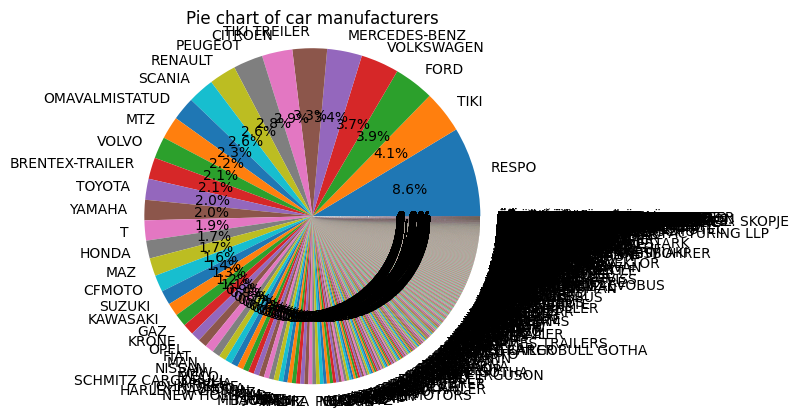

In [ ]:
category_counts = df['Mark'].value_counts()
plt.pie(category_counts, labels=category_counts.index, autopct='%1.1f%%')
plt.title('Pie chart of car manufacturers')
plt.axis('equal')
plt.show()

I will exclude "O" category vehicles (haagised / trailers) as they are of no interest

In [ ]:
categories_to_exclude = ['O1', 'O2', 'O3', 'O4']
df = df[~df['Kategooria'].isin(categories_to_exclude)]

In [ ]:
print(df['Kategooria'].unique())

['R3A' 'L1e' 'R2A' 'TH' 'LM' 'L3e' 'L7e' 'L6e' 'T3b' 'N1' 'T4.3a' 'T2a'
 'TR' 'TH1' 'R4A' 'T2' 'L2e' 'MS1' 'N3G' 'N1G' 'N2' 'N2G' 'R3B' 'R4B' 'T1'
 'MS2' 'T1a' 'T5' 'T3' 'M3' 'R1A' 'L5e' 'N3' 'L4e' 'T1b' 'T2b' 'T3a'
 'T4.3' 'TR1' 'C4.2' 'C1' 'M2' 'RO' 'R2B' 'T4.2' 'TR2' 'R1B']


What is the number of unique car manufacturers according to the database?

In [ ]:
unique_manufacturers_count = df['Mark'].nunique()
print(f'There are {unique_manufacturers_count} unique car manufacturers')

There are 1761 unique car manufacturers


Due to the fact that there are many errors in the dataset and the "Manufacturer" field will contains such values as "IVECO INDBUS ITALMAK D.O.O.E.L. SKOPJE", "Annaburger" or "SCHMITZ CARGOBULL GOTHA" only the categories that contain the most vehicles will be displayed. The rest will be shown under "other".\
 I will combine minor manufacturers into "Others" category on a pie chart.

In [ ]:
#count the number of vehicles for each manufacturer
manufacturer_counts = df['Mark'].value_counts()

# the number of vehicles, below which the manufactured will belong to "others"
threshold = 2000

minor_manufacturers = manufacturer_counts[manufacturer_counts < threshold].index
manufacturer_counts.loc['Others'] = manufacturer_counts[minor_manufacturers].sum()
manufacturer_counts = manufacturer_counts.drop(minor_manufacturers)

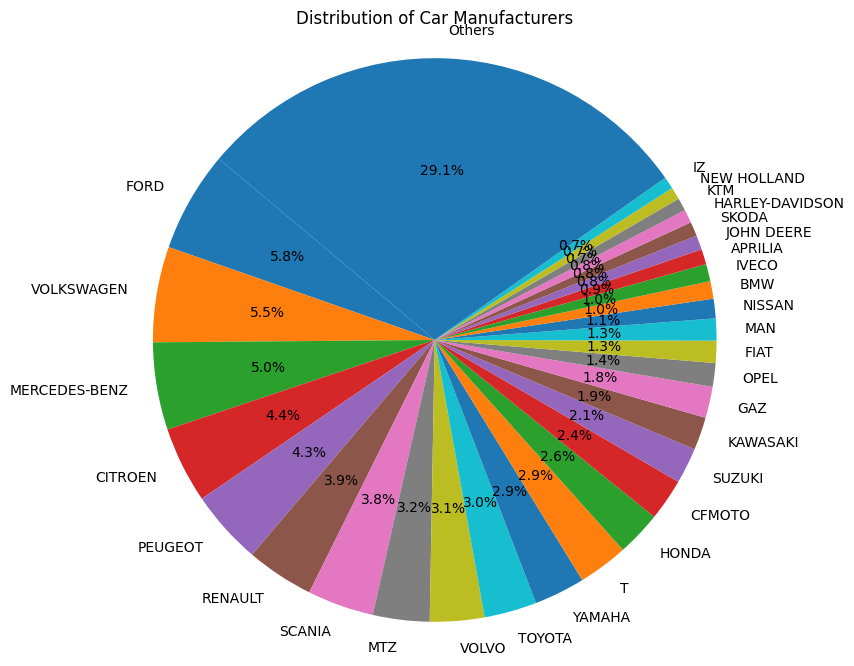

In [ ]:
plt.figure(figsize=(8, 8))
plt.pie(manufacturer_counts, labels=manufacturer_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Car Manufacturers')
plt.axis('equal')
plt.show()

Let's investigate closer. Here is a full list of Ford models

In [ ]:
ford_models = df[df['Mark'] =='FORD']['Mudel'].unique()
print(ford_models)

['TRANSIT' 'TRANSIT 120L VAN' 'F600' 'ALFKA' 'TRANSIT 100 SCAB' 'ALFKA R2'
 'TRANSIT 160L DCAB' 'TRANSIT 100L VAN' 'TRANSIT 100 VAN'
 'TRANSIT 120 VAN' 'TRANSIT 190L VAN' 'CARGO 1115' 'TRANSIT 100'
 'TRANSIT 190L SCAB' 'TRANSIT 190' 'ESCORT' 'ECONOVAN' 'TRANSIT 130 VAN'
 'TRANSIT 100L KOMBI' 'TRANSIT 130L VAN' 'ECONOLINE E350 SUPER VAN'
 'TRANSIT 80 VAN' 'CARGO D0707' 'TRANSIT 100 KOMBI' 'CARGO D0910 CUSTOM'
 'F250 XLT' 'TRANSIT 150L VAN' 'CARGO A0509' 'CARGO D0807 CUSTOM'
 'CARGO 0711' 'P100' 'TRANSIT 100 DCAB' 'CARGO 0912' 'CARGO 0812' '4000'
 '8200' 'CARGO 0811' 'CARGO D0710' 'TRANSIT 160L SCAB' 'EXPRESS'
 'TRANSIT 150 VAN' 'CARGO D1211' 'CARGO A0406' 'TRANSIT 190 VAN'
 'TRANSIT 150L DCAB' 'TRANSIT 190L KOMBI' 'TRANSIT 120 SCAB' 'F350 4X2'
 'TRANSIT 100L' 'CUSTOM D0707' 'TRANSIT 190L DCAB' 'FIESTA'
 'TRANSIT 80 DCAB' 'CARGO D1110 CUSTOM' 'TRANSIT 160 VAN' 'TRANSIT 130'
 'TRANSIT 160 KOMBI' 'CARGO 0608' 'TRANSIT 120' 'TRANSIT 120 KOMBI'
 'CARGO 1317' 'RANGER' 'TRANSIT 120 DCAB' 'CARG

It appears that the most popular car manufacturers are the ones that have vans (kaubik) in their product line.

I will plot a histogram of the age the vehicles are imported to Estonia.

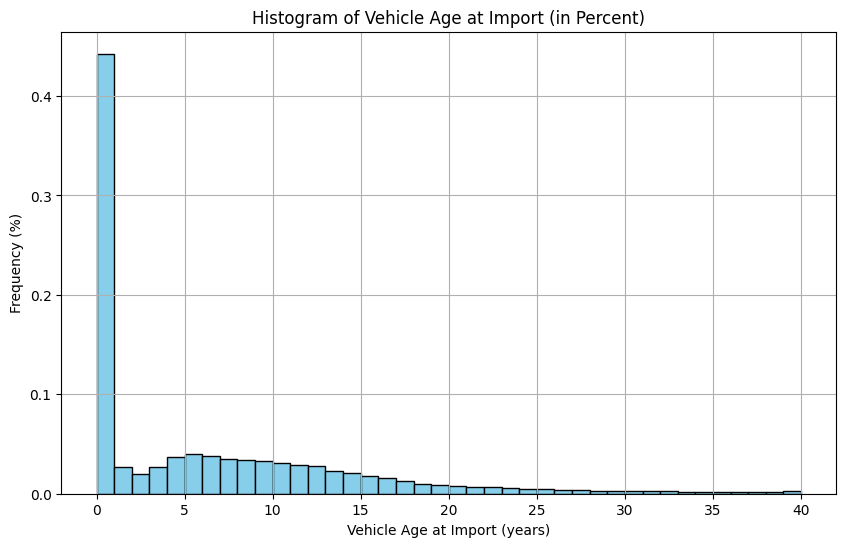

In [ ]:
df['vehicle_age_at_import'] = (df['EESTIS_ESMAREG_KP'] - df['ESMANE_REG_KP'])

plt.figure(figsize=(10, 6))
plt.hist(df['vehicle_age_at_import'], bins=40, range=(0, 40), density=True, color='skyblue', edgecolor='black')
plt.xlabel('Vehicle Age at Import (years)')
plt.ylabel('Frequency (%)')
plt.title('Histogram of Vehicle Age at Import (in Percent)')
plt.grid(True)
plt.show()

How many vehicles were imported at the age of 40?

In [ ]:
print(len(df[df['vehicle_age_at_import'] == 40]))

199


I would like to know what cars have the longest life span.

In [ ]:
# Calculate the life span of each vehicle
df['life_span'] = (datetime.datetime.now().year - df['ESMANE_REG_KP'])

# Group by manufacturer and calculate the average life span
average_life_span = df.groupby('Mark')['life_span'].mean().reset_index()

# Sort by average life span in descending order
average_life_span = average_life_span.sort_values(by='life_span', ascending=False)

print(average_life_span)


                      Mark  life_span
313     DOTTO-CASTELFRANCO     2024.0
333      EAGLE MOTORSPORTS     2024.0
998        MOTRON MOTORRAD     2024.0
1001                   MTL     2024.0
1684                    WO     2024.0
...                    ...        ...
1715               YOU NIU        1.0
1230                   RMH        1.0
1016                  MUTT        1.0
948   MERCEDES-BENZ POLSKA        1.0
945   MERCEDES-BENZ MERCUS        1.0

[1761 rows x 2 columns]


DOTTO-CASTELFRANCO and EAGLE MOTORSPORTS have great cars that serve for more than 2000 years. Apparently, manufacturing year is unknown and set to zero in the database. I need to filter that.\
I will extract the vehicles that are no more than 30 years old, because the older ones probably received special treatment as vintage and should not be taken into account.

In [ ]:
# filter vehicles of up to 30 years old
df_less30 = df[df['life_span'] <= 30]

# group by manufacturer
manufacturer_counts = df_less30['Mark'].value_counts()

# filter manufacturers that have at least a certain number of vehicles to sort out errors
threshold = 1000
filtered_manufacturers = manufacturer_counts[manufacturer_counts >= threshold]

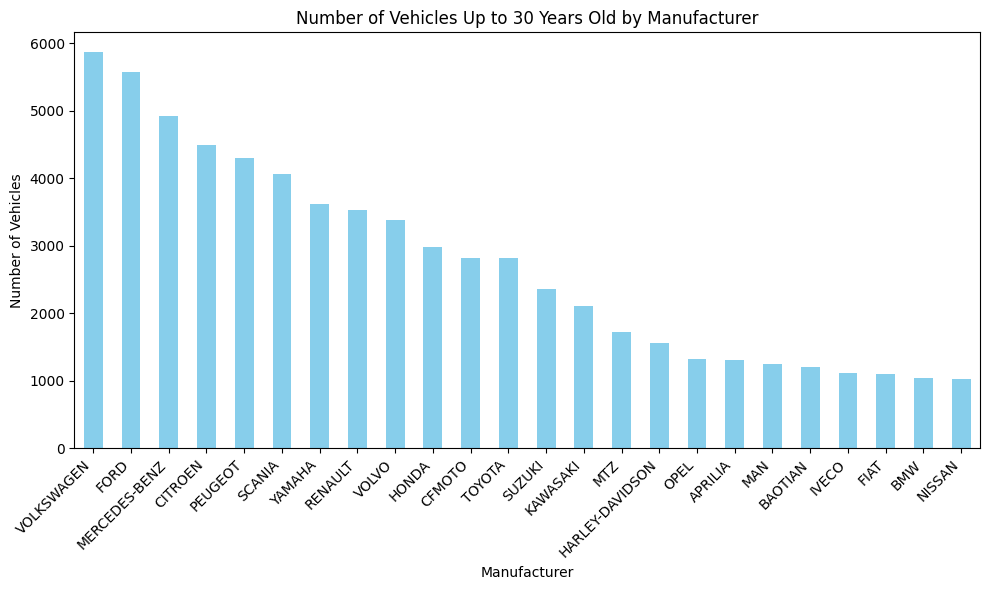

In [ ]:
plt.figure(figsize=(10, 6))
filtered_manufacturers.plot(kind='bar', color='skyblue')
plt.xlabel('Manufacturer')
plt.ylabel('Number of Vehicles')
plt.title('Number of Vehicles Up to 30 Years Old by Manufacturer')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Everyone know that the most common color in Estonia is grey, but let's confirm.

In [ ]:
most_frequent_color = df['VARV'].value_counts().idxmax()
print(f'The most frequent color is {most_frequent_color}')

The most frequent color is VALGE


The result is "VALGE" (white), however, I have a hypothesis that it may be caused by the fact that there are different shades of gray and cars fall into different categories. The database contains "HALL" (gray), "TUMEHALL" (dark gray), "HELEHALL" (light gray), and "HOBEDANE" (silver), I will combine them. I will also investigate the number of black cars, this is a popular color too.

In [ ]:
total_white = (df['VARV'].value_counts()).get('VALGE', 0)
print(f'There are {total_white} white cars')

total_simplegrey = (df['VARV'].value_counts()).get('HALL')
total_darkgrey = (df['VARV'].value_counts()).get('TUMEHALL')
total_lightgrey = (df['VARV'].value_counts()).get('HELEHALL')
total_silver = (df['VARV'].value_counts()).get('HOBEDANE')

total_grey = total_simplegrey + total_darkgrey + total_lightgrey + total_silver
print(f'There are {total_grey} grey cars')

total_black = (df['VARV'].value_counts()).get('MUST')
print(f'There are {total_black} black cars')


There are 72512 white cars
There are 33437 grey cars
There are 61945 black cars


White is still by far the prevalent color in Estonia, my hypothesis was wrong.

## Car (sõiduautod) sales forecast

### This is a file that contains car sales until the end of 2023

In [5]:
car_sales = pd.read_excel('/content/car-sales.xlsx')

In [6]:
car_sales.head()

,Aasta,January,February,March,April,May,June,July,August,September,October,November,December
0,2005,122,90,131,201,170,167,149,155,123,123,138,106
1,2006,186,131,172,234,260,242,252,249,204,196,188,155
2,2007,262,204,284,355,338,331,307,277,219,239,257,155
3,2008,288,203,229,260,279,237,222,147,149,243,172,136
4,2009,179,143,141,199,138,168,86,82,98,81,57,55


Cleaning and shaping the data

In [7]:
# importing data
data_long = pd.melt(car_sales, id_vars=['Aasta'], var_name='Month', value_name='Sales')

In [8]:
# converting to datetime format
data_long['Date'] = pd.to_datetime(data_long['Aasta'].astype(str) + data_long['Month'], format='%Y%B')

In [9]:
# Sort by Date
data_long = data_long.sort_values(by='Date')

In [10]:
# delete redundant columns
data_long.drop(columns=['Aasta', 'Month'], inplace=True)

In [11]:
# Set Date as index
data_long.set_index('Date', inplace=True)

In [12]:
data_long.head(3)

,Sales
Date,
2005-01-01,122
2005-02-01,90
2005-03-01,131


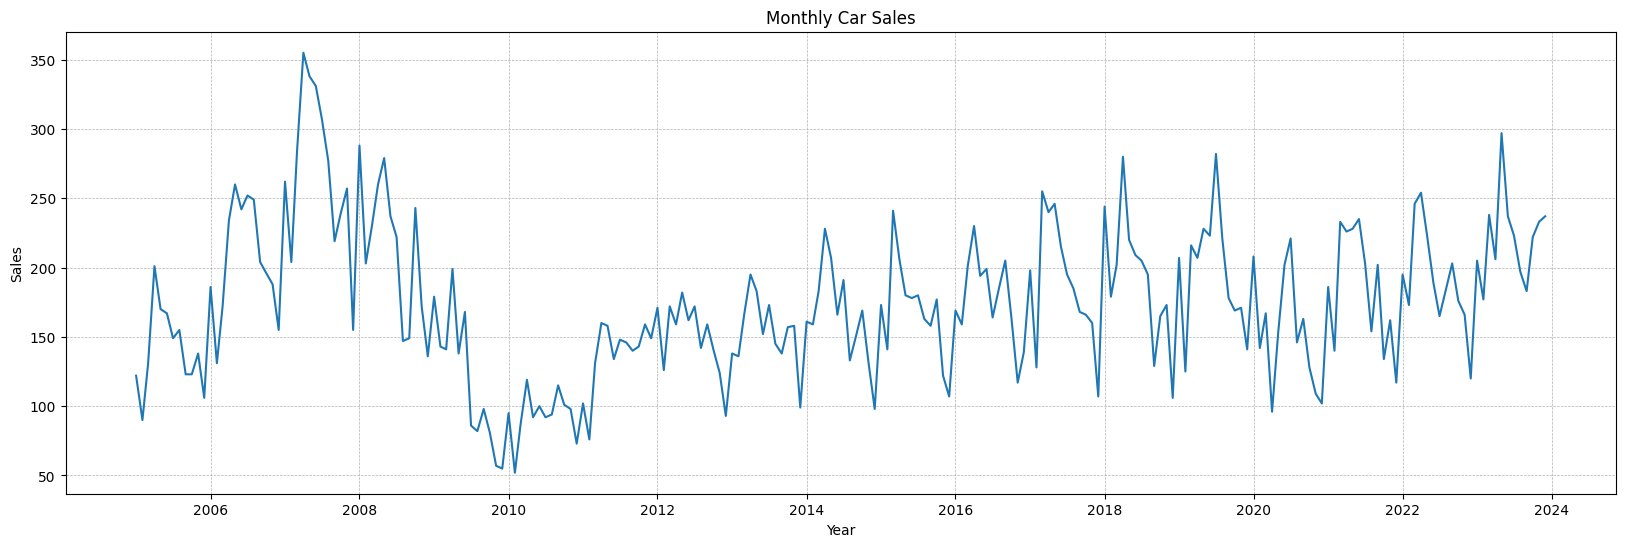

In [25]:
from matplotlib.dates import YearLocator, MonthLocator, DateFormatter
plt.figure(figsize=(20, 6))
plt.plot(data_long.index, data_long['Sales'])
plt.title('Monthly Car Sales')
plt.xlabel('Year')
plt.ylabel('Sales')
plt.grid(True, which='both', axis='both', linestyle='--', linewidth=0.5)
# plt.gca().xaxis.set_major_locator(MultipleLocator(1000))
# plt.gca().xaxis.set_major_locator(YearLocator())
# plt.gca().xaxis.set_major_formatter(DateFormatter('%Y'))
plt.show()

I will use car sales figures until the end of 2023 and try to forcast sales figures of 2024. The chart is clearly periodic, I will apply decompose function and SARIMA model.

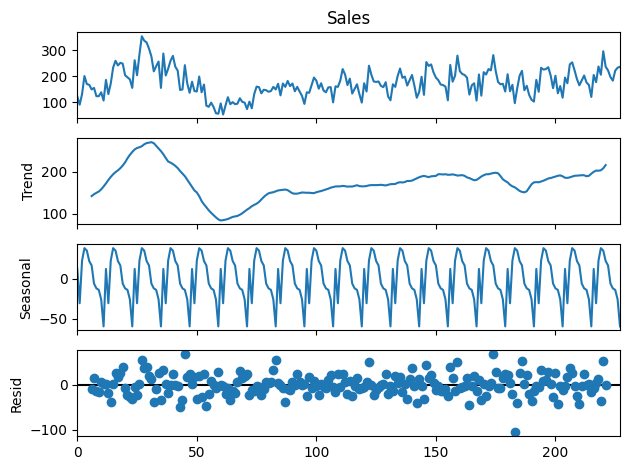

In [26]:
# Decompose the time series
data_long_reset = data_long.reset_index()
decomposition = seasonal_decompose(data_long_reset['Sales'], model='additive', period=12)  # Assuming 12-month seasonality
decomposition.plot()
plt.show()

In [27]:
# Stationarity check
result = adfuller(data_long['Sales'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: -2.931858488207437
p-value: 0.04176674156627658


In [28]:
# Differencing if the series is not stationary
if result[1] > 0.05:
    data_diff = data_long.diff().dropna()
else:
    data_diff = data_long

In [29]:
# Fit a SARIMA model
model = SARIMAX(data_long['Sales'], order=(1,1,1), seasonal_order=(1,1,1,12))
model_fit = model.fit(disp=False)
print(model_fit.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                              Sales   No. Observations:                  228
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -1036.031
Date:                            Wed, 05 Jun 2024   AIC                           2082.061
Time:                                    04:00:44   BIC                           2098.914
Sample:                                01-01-2005   HQIC                          2088.871
                                     - 12-01-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0532      0.112      0.476      0.634      -0.166       0.272
ma.L1         -0.5706      0.087   

In [30]:
# Forecasting
forecast = model_fit.get_forecast(steps=12)
forecast_ci = forecast.conf_int(alpha=0.05)

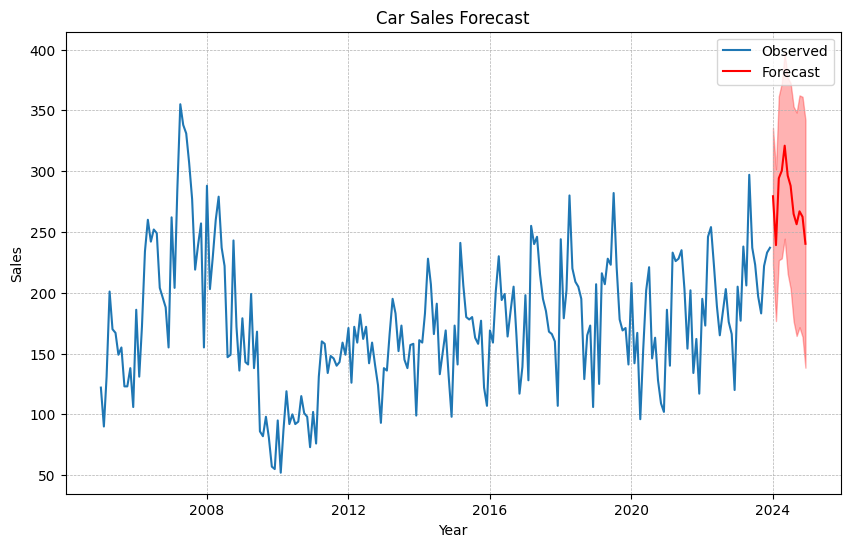

In [31]:
# Plotting the forecast without dates on the x-axis
plt.figure(figsize=(10, 6))
plt.plot(data_long.index, data_long['Sales'], label='Observed')
plt.plot(forecast.predicted_mean.index, forecast.predicted_mean, label='Forecast', color='red')
plt.fill_between(forecast_ci.index,
  forecast_ci.iloc[:, 0],
  forecast_ci.iloc[:, 1], color='red', alpha=0.3)
plt.xlabel('Year')
plt.ylabel('Sales')
plt.title('Car Sales Forecast')
plt.grid(True, which='both', axis='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.show()

### This is a file that contains car sales until May 2024

In [14]:
car_sales24 = pd.read_excel('/content/car-sales-2024.xlsx')

Cleaning and shaping the data

In [15]:
# importing data
data_long24 = pd.melt(car_sales24, id_vars=['Aasta'], var_name='Month', value_name='Sales')

In [16]:
# converting to datetime format
data_long24['Date'] = pd.to_datetime(data_long24['Aasta'].astype(str) + data_long24['Month'], format='%Y%B').fillna(0)

In [17]:
# Sort by Date
data_long24 = data_long24.sort_values(by='Date')

In [18]:
# delete redundant columns
data_long24.drop(columns=['Aasta', 'Month'], inplace=True)

In [19]:
# Set Date as index
data_long24.set_index('Date', inplace=True)

I will draw the data predicted for 2024 together with actual sales data to control the precision of the prediction.

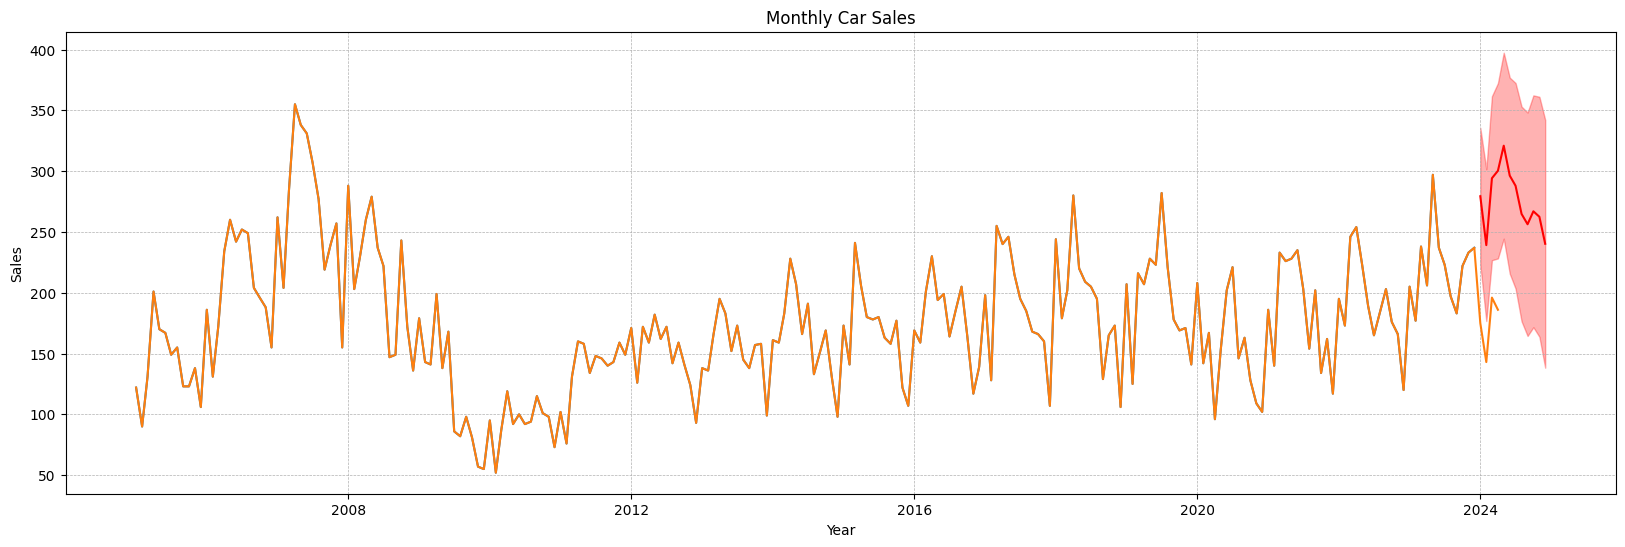

In [33]:
plt.figure(figsize=(20, 6))
plt.plot(data_long.index, data_long['Sales'], label='Observed')
plt.plot(forecast.predicted_mean.index, forecast.predicted_mean, label='Forecast', color='red')
plt.fill_between(forecast_ci.index,
  forecast_ci.iloc[:, 0],
  forecast_ci.iloc[:, 1], color='red', alpha=0.3)
plt.plot(data_long24.index, data_long24['Sales'])
plt.title('Monthly Car Sales')
plt.xlabel('Year')
plt.ylabel('Sales')
plt.grid(True, which='both', axis='both', linestyle='--', linewidth=0.5)
plt.show()

The actual sales are lower than predicted, but actually I obviously messed with prediction :-)